# CRNN

**Intro**

Dataset : Handwriting Recognition

Jumlah data yang digunakan :
- 30.000 training set
- 3000 validation set
- 3000 testing set

## Configuration
Berupa settingan value yang akan digunakan dalam penelitian.

In [1]:
# Configuration

# These vars represent the cropped image shape
H = 60 
W = 256

# Pool = 4
# PoolSize = 2
# LastFilter = 256

UnitClass = 30 # Number of characters
MaxInputCharLen = 24 # Max label length of input character
MaxPredictedCharLen = 64 # Max label length of predicted character
CTCTime = MaxPredictedCharLen - 2

BATCH_SIZE = 128 # x = train_size/batch_size -> (n-epoch/x ----- )
EPOCH = 20
TRAIN_SIZE = 30000 # Number of training sets that is used. 
VALID_SIZE = 3000 # Number of validation sets that is used.
TEST_SIZE = 3000 # Number of testing sets that is used.

## Variables
Menyimpan lokasi directory yang digunakan.

In [2]:
# Define variable for directory
def image_dir(base_img):
    train_dir = base_img + '\\train_v2\\train'
    test_dir = base_img + '\\test_v2\\test'
    valid_dir = base_img + '\\validation_v2\\validation'
    
    return train_dir, test_dir, valid_dir

def csv_dir(base_csv):
    train_csv_dir = base_csv + '/written_name_train_v2.csv'
    test_csv_dir = base_csv + '/written_name_test_v2.csv'
    valid_csv_dir = base_csv + '/written_name_validation_v2.csv'
    
    return train_csv_dir, test_csv_dir, valid_csv_dir

## Dataset
Berisi function yang digunakan untuk melakukan eksplorasi dataset (pengecekan, pembersihan data) dan pemrosesan data.

In [3]:
import pandas as pd
import numpy as np
import cv2

# DATASET
def read_csv_dir(train, test, valid):
    df_train = pd.read_csv(train)
    df_test = pd.read_csv(test)
    df_valid = pd.read_csv(valid)
    
    return df_train, df_test, df_valid

# Check nan data in dataframe
def nan_data(dataframe, *args):
    """ 
    params:
        dataframe -> data
        *args -> label
    """
    num_args=len(args)
    
    final_res = []
    for data in dataframe:
        bool_res_ = []
        for i in range(num_args):
            bool_res = True if ( data.isna().sum()[args[i]] != 0 ) else False
            bool_res_.append(bool_res)
            
        if bool_res_.__contains__(True):
            final_res.append(True)
        else:
            final_res.append(False)
        
        bool_res_.clear()
        
    return final_res

# Drop nan data
def drop_nan(dataframe, axis=0, inplace=False):
    if not inplace:
        df = dataframe.dropna(axis=axis, inplace=inplace)
        return df
    else:
        dataframe.dropna(axis=axis, inplace=inplace)
        return None

# Reset index of data in dataframe
def _reset_index_(dataframe, inplace=False, drop=False):
    if not inplace:
        df = dataframe.reset_index(inplace=inplace, drop=drop)
        return df
    else:
        dataframe.reset_index(inplace=inplace, drop=drop)
        return None 

def crop_image(image, dim=(64,128)):
    # Check the input image
    (h, w) = image.shape 
    
    # Modify the image to the new size, if as following:
    if h > dim[0]:
        image = image[:dim[0], :]
    
    if w > dim[1]:
        image = image[:, :dim[1]]
    
    # Create white blank image
    new_img = np.ones(dim)*255 

    # Fill the new image with the array we got after cropping(modifying)
    new_img[:h, :w] = image 
    
    # Here I'm just rotating the image to make it easier when reshaping and to ensure the integration of its data
    return cv2.rotate(new_img, cv2.ROTATE_90_CLOCKWISE)

# Label the character of the input name to num and vice versa
def label_name(name, name_to_num=True):
    # Character that is written in dataset (csv file) 
    alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ'- "
    
    label = []
    if name_to_num:
        # Convert the name to uppercase
        name = name.upper()
        for chars in name:
            num = alphabets.find(chars)
            label.append(num)
        return np.array(label)
    
    else:
        chars=""
        for nums in name:
            chars += alphabets[nums]
        return chars

# Funct to label each char of the name in dataframe
def label(df, size, max_char_len, label_base):
    # Create new Label (output label) for dataset padded with the label of each char of the name
    y_ = np.ones([size, max_char_len])*-1
    # This var counts the length of the name. 
    y_len = np.zeros([size, 1])
    
    # Label all the training set
        # The remaining unlabeled pads will be padded with -1
    for i in range(size):
        y_len[i] = len(df.loc[i, label_base])
        y_[i, :len(df.loc[i, label_base])] = label_name(name=df.loc[i, label_base])
    
    return y_, y_len
        

## Handwriting
Main

In [4]:
import cv2
import os
import numpy as np

def IMGCrop(path, size, data):
    img_arr = []
    for i in range(size):
        img_dir = os.path.join(path, data.loc[i, 'FILENAME'])
        img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE) # Grayscale channel 1
        img = crop_image(img, dim=(H, W))
        
        # cv2.imshow('image', img)
        # cv2.waitKey(0) 
        # cv2.destroyAllWindows()

        # Normalize the value of the image
        img = img/255.
        img_arr.append(img)
    
    img_arr = np.array(img_arr)
    return img_arr

In [33]:
BASE = 'C:\\Clarenti\\Data\\Project\\ML\\Program\\Dataset\\Recognition\\Handwriting'

# DEFINE VARIABLES
train_dir, test_dir, valid_dir = image_dir(BASE)
train_csv_dir, test_csv_dir, valid_csv_dir = csv_dir(BASE)

# READ CSV
df_train, df_test, df_valid = read_csv_dir(train_csv_dir, test_csv_dir, valid_csv_dir)
print(df_train.shape)
print(df_valid.shape)

# CHECK FOR NAN DATA
is_nan = nan_data([df_train, df_valid], 'FILENAME', 'IDENTITY')
print({'train_nan':is_nan[0], 'valid_nan':is_nan[1]})

# DROP NAN
drop_nan(df_train, inplace=True)
drop_nan(df_valid, inplace=True)
drop_nan(df_test, inplace=True)

# REMOVE INVALID DATA
df_train = df_train[df_train['IDENTITY']!='UNREADABLE']
df_valid = df_valid[df_valid['IDENTITY']!='UNREADABLE']
df_test = df_test[df_test['IDENTITY']!='UNREADABLE']

print('CURRENT TRAIN : ', df_train.shape)
print('CURRENT_VALID : ', df_valid.shape)

# RESET INDEX ON DATAFRAME AFTER FILTERING
_reset_index_(df_train, inplace=True, drop=True)
_reset_index_(df_valid, inplace=True, drop=True)
_reset_index_(df_test, inplace=True, drop=True)

print(df_train.tail(5))


(330961, 2)
(41370, 2)
{'train_nan': True, 'valid_nan': True}
CURRENT TRAIN :  (330294, 2)
CURRENT_VALID :  (41280, 2)
                FILENAME       IDENTITY
330289  TRAIN_330957.jpg          LENNY
330290  TRAIN_330958.jpg        TIFFANY
330291  TRAIN_330959.jpg  COUTINHO DESA
330292  TRAIN_330960.jpg         MOURAD
330293  TRAIN_330961.jpg        HELOISE


In [34]:
#==========================================================    
# IMAGE PREPROCESSING

# CROP IMAGE
X_train = IMGCrop(train_dir, TRAIN_SIZE, df_train)
X_valid = IMGCrop(valid_dir, VALID_SIZE, df_valid)
X_test = IMGCrop(test_dir, TEST_SIZE, df_test)

print('CURRENT TRAIN : ', X_train.shape)
print('CURRENT VALID : ', X_valid.shape)

# RESHAPE
X_train = np.array(X_train).reshape(-1, W, H, 1) # -1 -> =value digabung/diwrap jadi 1
X_valid = np.array(X_valid).reshape(-1, W, H, 1)
X_test = np.array(X_test).reshape(-1, W, H, 1)

print('CURRENT TRAIN AFTER RESHAPE : ', X_train.shape)
print('CURRENT VALID AFTER RESHAPE : ', X_valid.shape)

CURRENT TRAIN :  (30000, 256, 60)
CURRENT VALID :  (3000, 256, 60)
CURRENT TRAIN AFTER RESHAPE :  (30000, 256, 60, 1)
CURRENT VALID AFTER RESHAPE :  (3000, 256, 60, 1)


## Model and CTC

Digunakan untuk melakukan interpretasi terhadap variable input dengan label target.

*CTC approach was introduced, originally for speech recognition 
and afterwards also for handwriting recognition. CTC makes it 
possible to avoid the previously mentioned direct alignment 
between the input variables and the target labels by interpreting the 
output of the network as a probability distribution over all possible 
label sequences on the given input sequence.*

In [7]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import initializers
from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

In [8]:
# The aim of weight initialization is to prevent layer activation outputs from exploding or vanishing 
# during the course of a forward pass through a deep neural network.
# https://www.projectpro.io/recipes/explain-with-example-he-normal-initializer-work

input = Input(shape=(W, H, 1), name='INPUT')
conv1 = Conv2D(32, kernel_size=(3,3), padding='same', kernel_initializer=initializers.HeNormal, name='CONV1')(input)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)

pool1 = MaxPooling2D(pool_size=(2,2), name='POOL1')(conv1)

conv2 = Conv2D(64, kernel_size=(3,3), padding='same', kernel_initializer=initializers.HeNormal, name='CONV2')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)

pool2 = MaxPooling2D(pool_size=(2,2), name='POOL2')(conv2)
pool2 = Dropout(0.2)(pool2)

conv3 = Conv2D(128, kernel_size=(3,3), kernel_initializer=initializers.HeNormal, padding='same', name='CONV3')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)

pool3 = MaxPooling2D(pool_size=(1,2), name='POOL3')(conv3)
pool3 = Dropout(0.2)(pool3)

# layers = Conv2D(256, kernel_size=(3,3), padding='same', kernel_initializer=initializers.HeNormal, name='CONV4')(layers)
# layers = BatchNormalization()(layers)
# layers = Activation('relu')(layers)

# pool4 = MaxPooling2D(pool_size=(1,2), name='POOL4')(pool3)
# pool4 = Dropout(0.2)(pool4)

# conv4 = Conv2D(64, kernel_size=(3,3), padding='same', name='CONV4')(pool3)
# conv4 = BatchNormalization()(conv4)
# conv4 = Activation('relu')(conv4)

# pool4 = MaxPooling2D(pool_size=(1,2), name='POOL5s')(conv4)
# pool4 = Dropout(0.2)(pool4)

# #RNN
layers = Reshape(target_shape=(64, 896))(pool3)
layers = Dense(64, activation='relu', kernel_initializer=initializers.HeNormal, name='DENSE1')(layers)

layers = Bidirectional(LSTM(256, return_sequences=True, name='LSTM'))(layers)
layers = Bidirectional(LSTM(256, return_sequences=True, name='LSTM2'))(layers)
# layers = Bidirectional(LSTM(128, return_sequences=True, name='LSTM3'))(layers)

layers = Dense(UnitClass, kernel_initializer=initializers.HeNormal)(layers)
y_pred = Activation('softmax')(layers)
# y_pred = Dense(conf.UnitClass, activation='softmax', kernel_initializer=initializers.HeNormal, name='OUTPUT')(layers)
# y_pred = Bidirectional(LSTM(const.UnitClass, activation='softmax'))(layers)

model = Model(inputs=input, outputs=y_pred)
model.summary()
tf.keras.utils.plot_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 256, 60, 1)]      0         
                                                                 
 CONV1 (Conv2D)              (None, 256, 60, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 60, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 60, 32)       0         
                                                                 
 POOL1 (MaxPooling2D)        (None, 128, 30, 32)       0         
                                                                 
 CONV2 (Conv2D)              (None, 128, 30, 64)       18496     
                                                             

In [9]:
# https://github.com/GireeshS22/Handwriting-CNN-LSTM/blob/master/time_distributed_cnn_lstm_test.py

# Define these Input labels required for ctc
labels = Input(name='labels', shape=[MaxInputCharLen], dtype='float32')
input_len = Input(shape=[1], dtype='int64')
label_len= Input(shape=[1], dtype='int64')

train_input_len, valid_input_len = np.ones([TRAIN_SIZE, 1]) * CTCTime, np.ones([VALID_SIZE, 1]) * CTCTime
train_output = np.zeros([TRAIN_SIZE])
valid_output = np.zeros([VALID_SIZE])

# Get the target label
y_train, y_train_len = label(df_train, TRAIN_SIZE, MaxInputCharLen, 'IDENTITY')
y_valid, y_valid_len = label(df_valid, VALID_SIZE, MaxInputCharLen, 'IDENTITY')

# Since RNNs are powerful for sequence learning, they require pre-segmented training data, 
# Each character in the label needs to be aligned to it location of occurrence in the input image.
# Post-processing techniques are required on the output of RNN, which is a probability matrix, to transform it to the actual sequence of labels. 
# Connectionist Temporal Classification (CTC) is used to get those jobs above done. 
def ctc_loss_func(args):
    y_pred, y_true, input_len, label_len = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage.
    y_pred = y_pred[:,2:,:]
    return K.ctc_batch_cost(y_true, y_pred, input_len, label_len)

# y_pred : the model of its prediction
ctc = Lambda(ctc_loss_func, output_shape=(1,), name='ctc')([y_pred, labels, input_len, label_len]) 

In [10]:
# Create new model implement with ctc ouput
model_ = Model(inputs=[input, labels, input_len, label_len], outputs=ctc)

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss'))<2.04:
      print('\nReached 2% validation_loss so cancel the training')
      self.model.stop_training = True

# Define model
callbacks=MyCallback()

In [12]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
# sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

adam = Adam(learning_rate=0.001)

model_.compile(
    loss={
        'ctc': lambda y_true, y_pred: y_pred
    },
    optimizer=adam
)

model_.fit(x=[X_train, y_train, train_input_len, y_train_len], y=train_output,
            validation_data=([X_valid, y_valid, valid_input_len, y_valid_len], valid_output),
            epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=callbacks)


Epoch 1/20
235/235 [==============================] - 1641s 7s/step - loss: 21.4761 - val_loss: 20.5210
Epoch 2/20
235/235 [==============================] - 1621s 7s/step - loss: 17.0479 - val_loss: 18.7093
Epoch 3/20
235/235 [==============================] - 1566s 7s/step - loss: 5.8196 - val_loss: 20.4614
Epoch 4/20
235/235 [==============================] - 1612s 7s/step - loss: 3.3037 - val_loss: 3.1440
Epoch 5/20
235/235 [==============================] - 1807s 8s/step - loss: 2.5631 - val_loss: 2.5596
Epoch 6/20
235/235 [==============================] - 1589s 7s/step - loss: 2.2182 - val_loss: 2.6959
Epoch 7/20
235/235 [==============================] - 1683s 7s/step - loss: 2.0178 - val_loss: 8.6830
Epoch 8/20
235/235 [==============================] - 1657s 7s/step - loss: 1.9130 - val_loss: 4.4925
Epoch 9/20
235/235 [==============================] - 1610s 7s/step - loss: 1.7304 - val_loss: 2.1475
Epoch 10/20
235/235 [==============================] - 1600s 7s/step - loss: 

## Predict

In [37]:
def predict(model, x_, size):
    # try predict the data
    pred = model.predict(x_)
    # var to sum up the total of the given input
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # read the value of the variable of ctc we trained before, then decode the prediction
    decoded = K.get_value(K.ctc_decode(pred, input_length=input_len)[0][0])
    
    preds = []
    for i in range(size):
        decoded_name = label_name(decoded[i], name_to_num=False)
        preds.append(decoded_name)
    
    return preds

def prediction_accuracy_metrics(data, preds, size, features):
    valid_feature_names = data.loc[:size, features]
    
    corr_words = 0 # init var to check if model has predicted correct name
    corr_char = 0 # init var to check if the model has guessed correctly the character of each names
    total_char = 0
    for i in range(size): # loop validation set
        # Check and compare decoded predicted name with the true name of the validation set 
        valid_features = valid_feature_names[i]
        preds_features = preds[i]
        total_char += len(valid_features)
        for j in range(min(len(valid_features), len(preds_features))):
            if valid_features[j] == preds_features[j]:
                corr_char += 1

        if(valid_features.strip()==preds_features.strip()):
            corr_words += 1

    print('total character : ', total_char)
    char_predict_accuracy = float(corr_char*100/total_char)
    word_predict_accuracy = float(corr_words*100/size)
    return char_predict_accuracy, word_predict_accuracy

In [38]:
valid_preds = predict(model, X_valid, VALID_SIZE)
valid_char_acc, valid_word_acc = prediction_accuracy_metrics(df_valid, valid_preds, VALID_SIZE, 'IDENTITY')
dicts = {
    "Accuracy of char prediction : " : valid_char_acc,
    "Accurancy of word prediction : " : valid_word_acc
}
print(dicts)

94/94 [==============================] - 71s 749ms/step
total character :  19678
{'Accuracy of char prediction : ': 91.93515601178981, 'Accurancy of word prediction : ': 77.53333333333333}


1/1 [==============================] - 0s 85ms/step
KEVIN                                                           
1/1 [==============================] - 0s 78ms/step
EO                                                              
1/1 [==============================] - 0s 82ms/step
LENA                                                            
1/1 [==============================] - 0s 82ms/step
JULES                                                           
1/1 [==============================] - 0s 69ms/step
CHERPIN                                                         
1/1 [==============================] - 0s 70ms/step
MARTIN                                                          
1/1 [==============================] - 0s 71ms/step
VALENTINE                                                       
1/1 [==============================] - 0s 69ms/step
LORAS                                                           
1/1 [==============================] - 0s 68ms/step
THIBAULT    

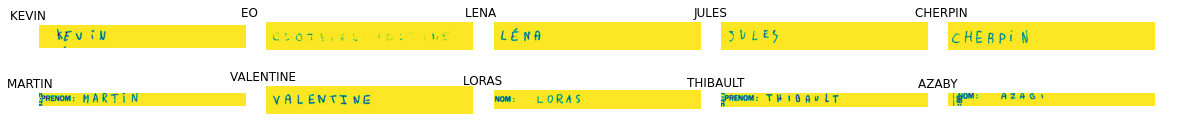

In [16]:
plt.figure(figsize=(20, 2))
for i in range(10):
    # show test image
    ax = plt.subplot(2, 5, i+1)
    img_dir = os.path.join(test_dir, df_test.loc[i, 'FILENAME'])
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img)
    
    # show predicted names
    image = crop_image(img, dim=(H, W))
    image = image/255.
    pred = model.predict(image.reshape(1, W, H, 1))

    # pred = model.predict(X_test)
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = K.get_value(K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]) # decode the predicted names
    print(label_name(decoded[0], name_to_num=False))
    plt.title(label_name(decoded[0], name_to_num=False)) # Convert the decoded to be name string
    plt.axis('off')

# Adjust plot space
plt.subplots_adjust(wspace=0.1, hspace=0.4)

1. SIZE {train = 30000, valid = 3000, test = 100 }; OPT = ADAM; EPOCH = 5 (N-5 VAL LOSS = 4.0813); BATCH = 128; 3 CONV 2 BI-LSTM(256); ACC = 79.45%
2. SIZE {train = 30000, valid = 3000, test = 100 }; OPT = ADAM; EPOCH = 8 (N-8 LOSS = 1.83 w/ callback if val_loss < 3.0); BATCH = 128; 3 CONV(kernel_init = HeNormal) 2 BI-LSTM(256); ACC = 82.89%
3. SIZE {train = 30000, valid = 3000, test = 100 }; OPT = ADAM; EPOCH = 20 (N-10 LOSS = 1.69 val_loss=1.96 w/ callback if val_loss < 2.04); BATCH = 128; 3 CONV(kernel_init = HeNormal) 3 POOL(Last 2 pools has dropout=0.2) 2 BI-LSTM(256); VALID__CHAR_ACC = 91%, TESTING_CHAR_ACC = 91% 

In [39]:
test_preds = predict(model, X_test, TEST_SIZE)
test_char_acc, test_word_acc = prediction_accuracy_metrics(df_test, test_preds, TEST_SIZE, 'IDENTITY')
test_dicts = {
    "Accuracy of char prediction : " : test_char_acc,
    "Accurancy of word prediction : " : test_word_acc
}
print(test_dicts)

94/94 [==============================] - 65s 690ms/step
total character :  19564
{'Accuracy of char prediction : ': 91.42813330607238, 'Accurancy of word prediction : ': 75.93333333333334}
